# Modeling Notebook

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE

In [2]:
# import dataset
df = pd.read_csv('..\\data\\telecom_data.csv')

# Handle object types for international plan and voice mail plan
df.loc[df['international plan'] == 'no', 'international plan'] = 0
df.loc[df['international plan'] == 'yes', 'international plan'] = 1 

df.loc[df['voice mail plan'] == 'no', 'voice mail plan'] = 0
df.loc[df['voice mail plan']== 'yes', 'voice mail plan'] = 1

# Change churn to values: 1 (churned/True) 0 (no churn/False)
df.loc[df['churn'] == True, 'churn'] = 1
df.loc[df['churn'] == False, 'churn'] = 0

# going to create backup df and drop phone number from original df
# phone number could be used as unique id, but it doesn't seem necessary
df_backup = df.copy()
df = df.drop(['phone number'], axis=1)

# casting int values to churn, voice mail plan, and international plan cols
objs = ['international plan', 'voice mail plan', 'churn']

for o in objs:
    df = df.astype({o: int})
    
# dropping area code
df = df.drop(['area code'], axis=1)

# check df
df.head()

,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


Handle international calls to bin them into categories easier.

In [3]:
# handle international calls to bin them into categories easier.
df['total intl calls'].value_counts()

3     668
4     619
2     489
5     472
6     336
7     218
1     160
8     116
9     109
10     50
11     28
0      18
12     15
13     14
15      7
14      6
18      3
16      2
19      1
17      1
20      1
Name: total intl calls, dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x2440a4ebee0>,
 'caps': [<matplotlib.lines.Line2D at 0x2440a5025e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2440a4ebb80>],
 'medians': [<matplotlib.lines.Line2D at 0x2440a502ca0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2440a50d040>],
 'means': []}

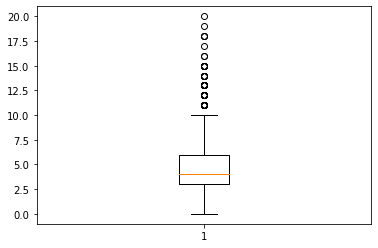

In [4]:
plt.boxplot(df['total intl calls'])

In [5]:
df['total intl calls'].describe()

count    3333.000000
mean        4.479448
std         2.461214
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max        20.000000
Name: total intl calls, dtype: float64

In [6]:
# range is 0-20 for international calls with most concentrated from 0-10
# I will bin into cats: low, moderate, and high with values <3, 3-6, and >6

list_tmp = []

for index, row in df.iterrows():
    if row['total intl calls'] < 3:
        list_tmp.append('low')
    elif row['total intl calls'] > 6:
        list_tmp.append('high')
    else:
        list_tmp.append('moderate')

df['total_intl_calls'] = list_tmp

df['total_intl_calls'].describe()

count         3333
unique           3
top       moderate
freq          2095
Name: total_intl_calls, dtype: object

What would be the % chance of guessing correctly if the customer was assumed to not churn?

In [8]:
1-df.churn.mean()

0.8550855085508551

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   international plan      3333 non-null   int32  
 3   voice mail plan         3333 non-null   int32  
 4   number vmail messages   3333 non-null   int64  
 5   total day minutes       3333 non-null   float64
 6   total day calls         3333 non-null   int64  
 7   total day charge        3333 non-null   float64
 8   total eve minutes       3333 non-null   float64
 9   total eve calls         3333 non-null   int64  
 10  total eve charge        3333 non-null   float64
 11  total night minutes     3333 non-null   float64
 12  total night calls       3333 non-null   int64  
 13  total night charge      3333 non-null   float64
 14  total intl minutes      3333 non-null   

Handle state and total_intl_calls object types. Turn these into integers for later modeling.

In [17]:
type(df.state[5])

str

In [20]:
type(states.index("WY"))

int

In [15]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA",
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA",
          "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY",
          "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX",
          "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

ValueError: invalid literal for int() with base 10: 'AL'

In [22]:
state_int = []
for i, row in df.iterrows():
    state_int.append(states.index(row['state']))

state_int

[16,
 35,
 30,
 35,
 36,
 0,
 21,
 25,
 18,
 48,
 14,
 39,
 15,
 26,
 15,
 32,
 12,
 45,
 46,
 43,
 9,
 5,
 2,
 40,
 46,
 27,
 50,
 26,
 25,
 11,
 13,
 29,
 18,
 2,
 36,
 10,
 1,
 21,
 1,
 30,
 10,
 20,
 3,
 12,
 49,
 37,
 22,
 8,
 12,
 50,
 15,
 14,
 46,
 44,
 50,
 14,
 5,
 5,
 49,
 36,
 12,
 4,
 23,
 41,
 33,
 47,
 50,
 23,
 44,
 43,
 30,
 23,
 31,
 28,
 11,
 23,
 7,
 32,
 23,
 20,
 48,
 37,
 5,
 10,
 43,
 45,
 14,
 48,
 17,
 30,
 7,
 18,
 3,
 19,
 2,
 1,
 26,
 2,
 24,
 12,
 15,
 21,
 45,
 17,
 14,
 2,
 22,
 31,
 5,
 44,
 22,
 21,
 0,
 8,
 2,
 19,
 30,
 28,
 25,
 12,
 27,
 43,
 20,
 24,
 28,
 2,
 24,
 24,
 43,
 27,
 27,
 4,
 30,
 43,
 3,
 0,
 32,
 9,
 1,
 28,
 8,
 20,
 22,
 45,
 45,
 22,
 47,
 44,
 18,
 39,
 15,
 27,
 35,
 39,
 36,
 18,
 35,
 46,
 25,
 9,
 40,
 46,
 15,
 22,
 36,
 8,
 10,
 7,
 2,
 0,
 5,
 29,
 31,
 37,
 18,
 27,
 23,
 22,
 3,
 16,
 48,
 1,
 32,
 29,
 46,
 31,
 32,
 2,
 50,
 47,
 5,
 43,
 17,
 26,
 36,
 20,
 42,
 43,
 19,
 7,
 23,
 8,
 20,
 22,
 47,
 25,
 14,
 37,
 20

In [23]:
df['state_int'] = state_int
df.columns

Index(['state', 'account length', 'international plan', 'voice mail plan',
       'number vmail messages', 'total day minutes', 'total day calls',
       'total day charge', 'total eve minutes', 'total eve calls',
       'total eve charge', 'total night minutes', 'total night calls',
       'total night charge', 'total intl minutes', 'total intl calls',
       'total intl charge', 'customer service calls', 'churn',
       'total_intl_calls', 'state_int'],
      dtype='object')

In [24]:
df.total_intl_calls.unique()

array(['moderate', 'high', 'low'], dtype=object)

In [25]:
intl_calls_int = []
for i, row in df.iterrows():
    if row['total_intl_calls'] == 'low':
        intl_calls_int.append(0)
    elif row['total_intl_calls'] == 'moderate':
        intl_calls_int.append(1)
    else:
        intl_calls_int.append(2)

df['intl_calls_bins'] = intl_calls_int
df.columns

Index(['state', 'account length', 'international plan', 'voice mail plan',
       'number vmail messages', 'total day minutes', 'total day calls',
       'total day charge', 'total eve minutes', 'total eve calls',
       'total eve charge', 'total night minutes', 'total night calls',
       'total night charge', 'total intl minutes', 'total intl calls',
       'total intl charge', 'customer service calls', 'churn',
       'total_intl_calls', 'state_int', 'intl_calls_bins'],
      dtype='object')

In [30]:
cats = ['state_int', 'international plan', 'intl_calls_bins',
        'customer service calls', 'voice mail plan']

# Baseline Model

In [26]:
y = df['churn']
# dropping # vmail messages because its distribution isn't normal
X = df.drop(['churn', 'total intl calls', 'number vmail messages',
             'total_intl_calls', 'state'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=24)

In [28]:
# Fixing class imbalance with SMOTE
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train)

In [31]:
X_train_cats = X_train_resampled[cats]
X_train_cats

,state_int,international plan,intl_calls_bins,customer service calls,voice mail plan
0,45,0,1,4,0
1,31,0,1,1,0
2,15,0,2,1,0
3,6,0,1,2,0
4,1,0,2,1,0
...,...,...,...,...,...
4269,39,0,0,3,1
4270,42,0,1,1,0
4271,18,1,0,3,0
4272,21,0,1,4,0


In [32]:
# handle categorical values
ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

ohe.fit(X_train_cats)
X_train_ohe = pd.DataFrame(
    ohe.transform(X_train_cats),
    index=X_train_cats.index,
    columns=np.hstack(ohe.categories_)
)
X_train_ohe

,0,1,2,3,4,5,6,7,8,9,...,1,2,3,4,5,6,7,8,0,1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [33]:
X_train_numerics = X_train_resampled.drop(cats, axis=1)
X_train_numerics

,account length,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl charge
0,142,232.500000,74,39.530000,181.800000,142,15.450000,203.100000,86,9.140000,10.400000,2.810000
1,232,165.600000,104,28.150000,195.900000,115,16.650000,118.300000,77,5.320000,11.800000,3.190000
2,128,158.800000,75,27.000000,264.800000,91,22.510000,270.000000,77,12.150000,7.600000,2.050000
3,134,177.200000,91,30.120000,228.700000,105,19.440000,194.300000,113,8.740000,8.900000,2.400000
4,141,83.200000,74,14.140000,190.600000,104,16.200000,150.500000,79,6.770000,10.700000,2.890000
...,...,...,...,...,...,...,...,...,...,...,...,...
4269,73,99.530033,82,16.918876,177.127493,103,15.054991,171.825969,104,7.728590,10.415111,2.808387
4270,164,281.758356,52,47.900070,168.279336,141,14.305944,265.050700,94,11.927806,8.999745,2.430931
4271,122,137.962440,102,23.457433,118.504790,103,10.074045,248.769624,124,11.198247,8.396761,2.267011
4272,39,174.150799,110,29.606565,210.879047,98,17.922183,138.899484,108,6.254977,9.221418,2.486425


In [34]:
# Scaling variables to work well with OHE data

scaler = MinMaxScaler()

scaler.fit(X_train_numerics)
X_train_scaled = pd.DataFrame(
    scaler.transform(X_train_numerics),
    index=X_train_numerics.index,
    columns=X_train_numerics.columns
)
X_train_scaled

,account length,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl charge
0,0.610390,0.662771,0.453988,0.662810,0.502488,0.835294,0.502439,0.443607,0.359712,0.443943,0.520000,0.520370
1,1.000000,0.472064,0.638037,0.471999,0.541459,0.676471,0.541463,0.197738,0.294964,0.197809,0.590000,0.590741
2,0.549784,0.452680,0.460123,0.452716,0.731896,0.535294,0.732033,0.637576,0.294964,0.637887,0.380000,0.379630
3,0.575758,0.505131,0.558282,0.505030,0.632117,0.617647,0.632195,0.418092,0.553957,0.418170,0.445000,0.444444
4,0.606061,0.237172,0.453988,0.237089,0.526810,0.611765,0.526829,0.291099,0.309353,0.291237,0.535000,0.535185
...,...,...,...,...,...,...,...,...,...,...,...,...
4269,0.311688,0.283723,0.503067,0.283683,0.489573,0.605882,0.489593,0.352931,0.489209,0.353002,0.520756,0.520072
4270,0.705628,0.803188,0.319018,0.803153,0.465117,0.829412,0.465234,0.623226,0.417266,0.623570,0.449987,0.450172
4271,0.523810,0.393279,0.625767,0.393317,0.327542,0.605882,0.327611,0.576021,0.633094,0.576562,0.419838,0.419817
4272,0.164502,0.496439,0.674847,0.496421,0.582861,0.576471,0.582835,0.257464,0.517986,0.258053,0.461071,0.460449


In [35]:
X_train_full = pd.concat([X_train_scaled, X_train_ohe], axis=1)
X_train_full

,account length,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,...,1,2,3,4,5,6,7,8,0,1
0,0.610390,0.662771,0.453988,0.662810,0.502488,0.835294,0.502439,0.443607,0.359712,0.443943,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.000000,0.472064,0.638037,0.471999,0.541459,0.676471,0.541463,0.197738,0.294964,0.197809,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.549784,0.452680,0.460123,0.452716,0.731896,0.535294,0.732033,0.637576,0.294964,0.637887,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.575758,0.505131,0.558282,0.505030,0.632117,0.617647,0.632195,0.418092,0.553957,0.418170,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.606061,0.237172,0.453988,0.237089,0.526810,0.611765,0.526829,0.291099,0.309353,0.291237,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4269,0.311688,0.283723,0.503067,0.283683,0.489573,0.605882,0.489593,0.352931,0.489209,0.353002,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4270,0.705628,0.803188,0.319018,0.803153,0.465117,0.829412,0.465234,0.623226,0.417266,0.623570,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4271,0.523810,0.393279,0.625767,0.393317,0.327542,0.605882,0.327611,0.576021,0.633094,0.576562,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4272,0.164502,0.496439,0.674847,0.496421,0.582861,0.576471,0.582835,0.257464,0.517986,0.258053,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [37]:
# model
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log = logreg.fit(X_train_full, y_train_resampled)
model_log

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [39]:
# Model Evaluation
y_hat_train = logreg.predict(X_train_full)

train_residuals = np.abs(y_train_resampled - y_hat_train)
print(pd.Series(train_residuals, name="Residuals (counts)").value_counts())
print()
print(pd.Series(train_residuals, name="Residuals (proportions)").value_counts(normalize=True))

0    3373
1     901
Name: Residuals (counts), dtype: int64

0    0.78919
1    0.21081
Name: Residuals (proportions), dtype: float64


Train set is about 79% accurate.

In [40]:
# performance evaluation on test set.
X_test_cats = X_test[cats]

# handle categorical values
ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

ohe.fit(X_test_cats)
X_test_ohe = pd.DataFrame(
    ohe.transform(X_test_cats),
    index=X_test_cats.index,
    columns=np.hstack(ohe.categories_)
)

X_test_numerics = X_test.drop(cats, axis=1)

# Scaling variables to work well with OHE data

scaler = MinMaxScaler()

scaler.fit(X_test_numerics)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_numerics),
    index=X_test_numerics.index,
    columns=X_test_numerics.columns
)

X_test_full = pd.concat([X_test_scaled, X_test_ohe], axis=1)
X_test_full

,account length,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,...,1,2,3,4,5,6,7,9,0,1
1834,0.566116,0.550536,0.527273,0.550596,0.562986,0.634146,0.562958,0.657635,0.782258,0.657680,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
104,0.500000,0.493774,0.569697,0.493867,0.409020,0.520325,0.408858,0.636184,0.338710,0.636364,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
105,0.388430,0.689545,0.393939,0.689608,0.451011,0.430894,0.450952,0.470787,0.661290,0.470846,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
980,0.202479,0.547061,0.569697,0.547019,0.502955,0.479675,0.502928,0.362969,0.733871,0.363009,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
936,0.371901,0.470026,0.648485,0.470017,0.596267,0.569106,0.596266,0.717471,0.491935,0.717241,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,0.285124,0.575152,0.672727,0.575128,0.534059,0.569106,0.534041,0.417725,0.580645,0.417555,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
260,0.095041,0.477556,0.666667,0.477513,0.519751,0.487805,0.519766,0.587073,0.177419,0.586834,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3136,0.438017,0.278888,0.503030,0.278876,0.427372,0.373984,0.427526,0.403895,0.709677,0.403762,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2979,0.404959,0.392992,0.648485,0.393015,0.516952,0.471545,0.516837,0.524414,0.500000,0.524138,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [41]:
y_hat_test = logreg.predict(X_test_full)

test_residuals = np.abs(y_test - y_hat_test)
print(pd.Series(test_residuals, name="Residuals (counts)").value_counts())
print()
print(pd.Series(test_residuals, name="Residuals (proportions)").value_counts(normalize=True))

0    622
1    212
Name: Residuals (counts), dtype: int64

0    0.745803
1    0.254197
Name: Residuals (proportions), dtype: float64


Train set is about 75% accurate.